In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)
importlib.reload(correct_drift)

start_date_str = '2023-08-16'
end_date_str = '2023-08-16'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '08558cba'
# imu_k3y_id = '17700cf8'

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

ValueError: No objects to concatenate

In [3]:
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str, False)
imu_df['vert_acc(m/s^2)'] = pd.to_numeric(imu_df['vert_acc(m/s^2)'], errors='coerce')

In [7]:
truth_df = fetch_data.get_imu_data(can_k3y_id, organization_id, start_date_str, end_date_str, False)

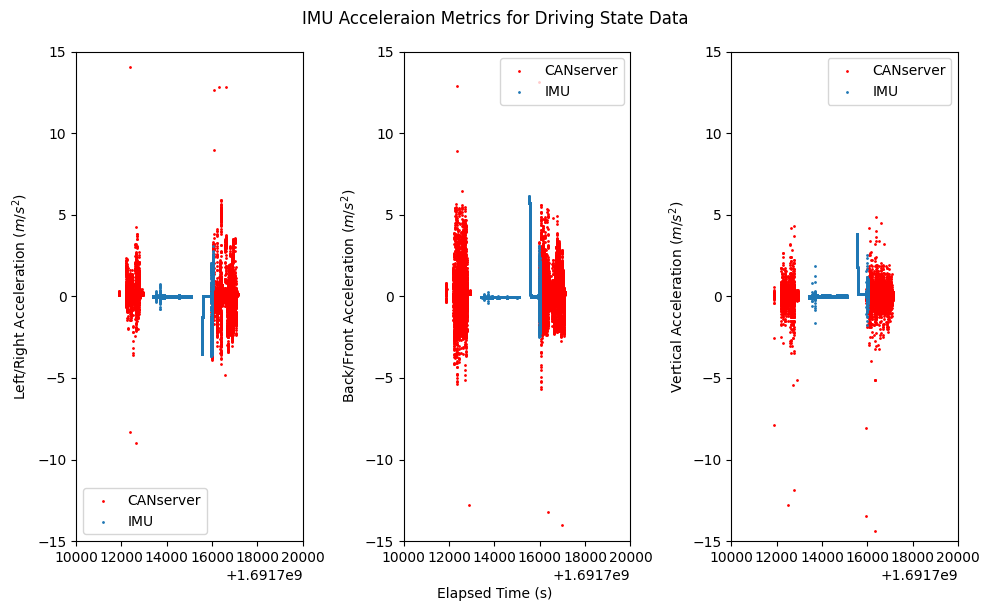

In [7]:
left = 10000 + 1.6917e9
right = 20000 + 1.6917e9

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10,6)

ax1.scatter(x=can_df['timestamp'], y=-can_df['lr_acc'], s=1, color='red', label='CANserver')
ax1.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)
ax1.set_xlim(left, right)

ax2.scatter(x=can_df['timestamp'], y=can_df['bf_acc'], s=1, color='red', label='CANserver')
ax2.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)
ax2.set_xlim(left, right)

ax3.scatter(x=can_df['timestamp'], y=can_df['vert_acc'], s=1, color='red', label='CANserver')
ax3.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)
ax3.set_xlim(left, right)

fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()

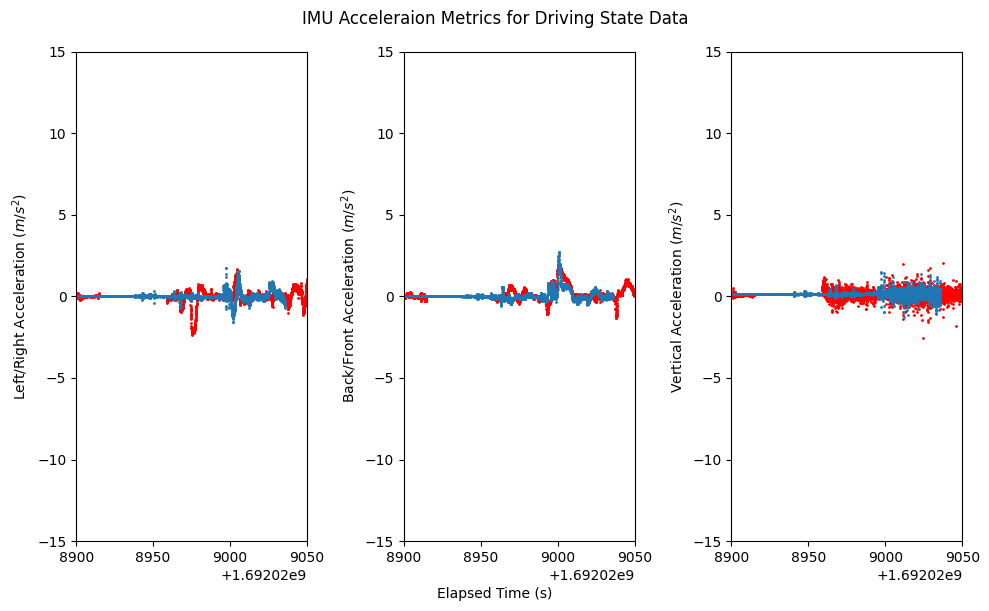

In [16]:
timestamp = 'timestamp(epoch in sec)'
# timestamp = 'correct_timestamp'
left = 28900 + 1.692 * 10**9
right = 29050 + 1.692 * 10**9

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10,6)

ax1.scatter(x=truth_df[timestamp], y=truth_df['lr_acc(m/s^2)'], color='red', s=1, label='Truth')
ax1.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)
ax1.set_xlim(left, right)

ax2.scatter(x=truth_df[timestamp], y=truth_df['bf_acc(m/s^2)'], color='red', s=1, label='Truth')
ax2.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)
ax2.set_xlim(left, right)

ax3.scatter(x=truth_df[timestamp], y=truth_df['vert_acc(m/s^2)'], color='red', s=1, label='Truth')
ax3.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)
ax3.set_xlim(left, right)

fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

# ax1.legend()
# ax2.legend()
# ax3.legend()
plt.tight_layout()
plt.show()

1


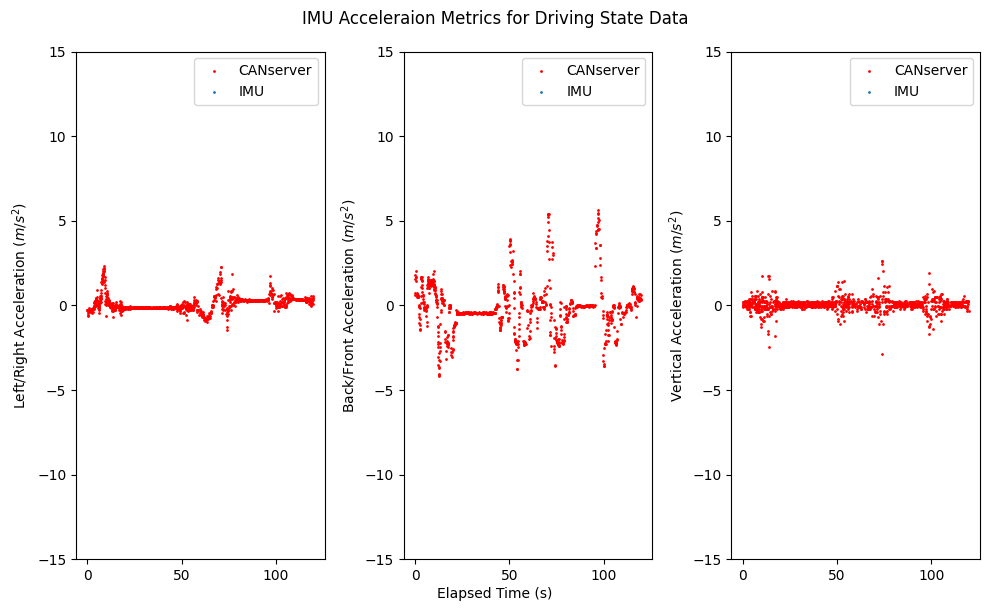

2


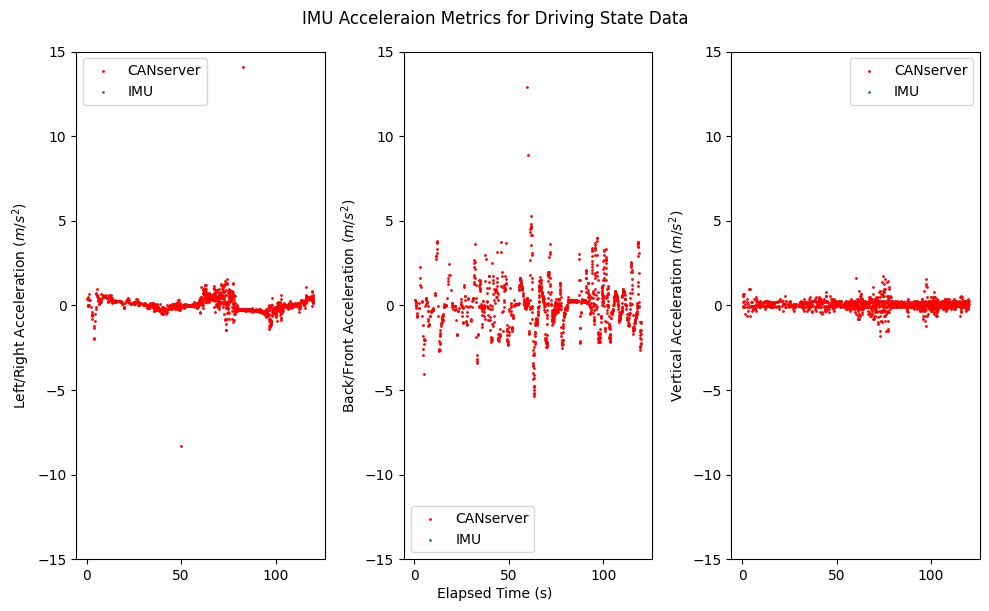

3


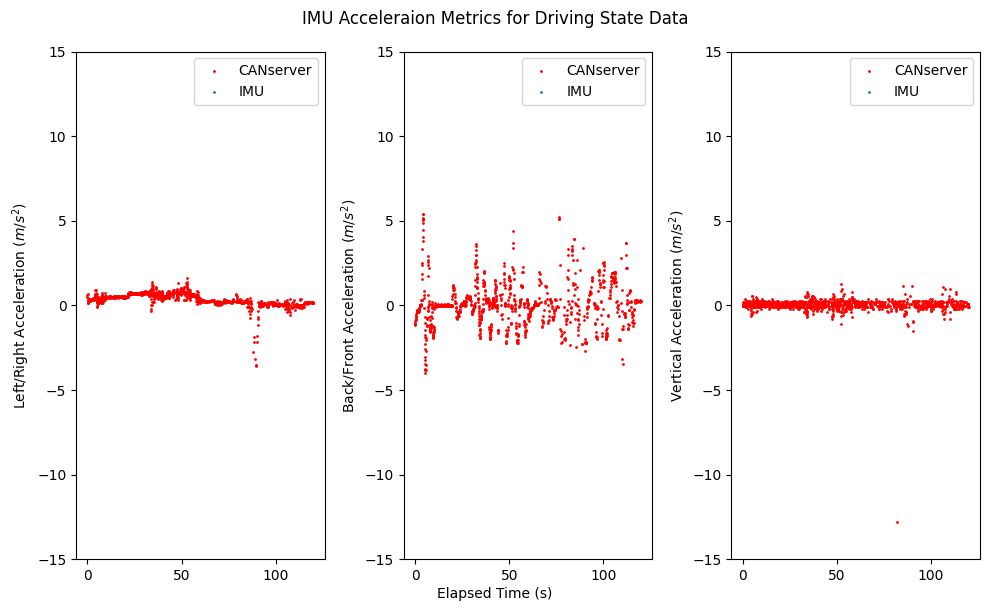

4


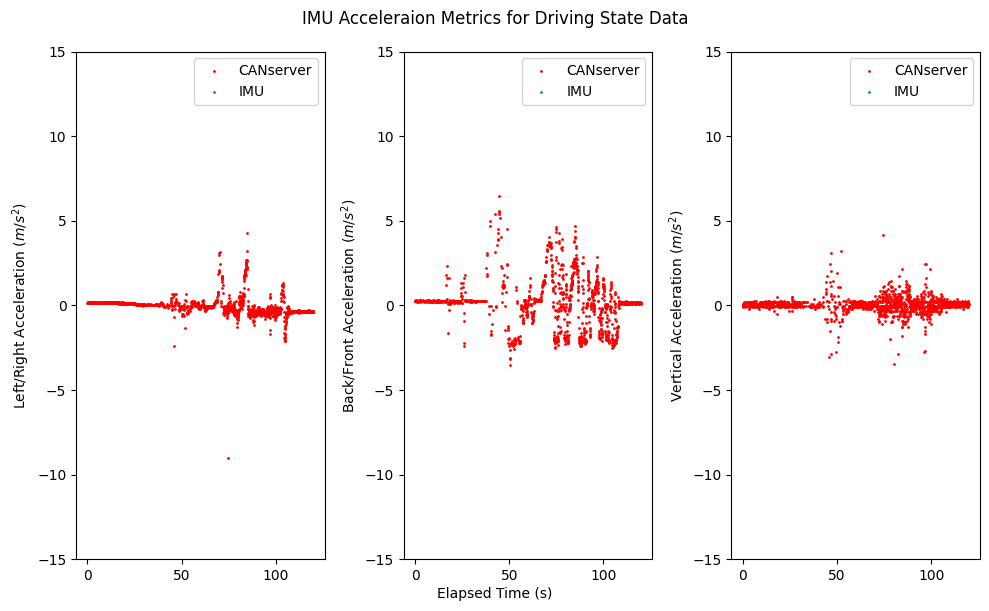

5


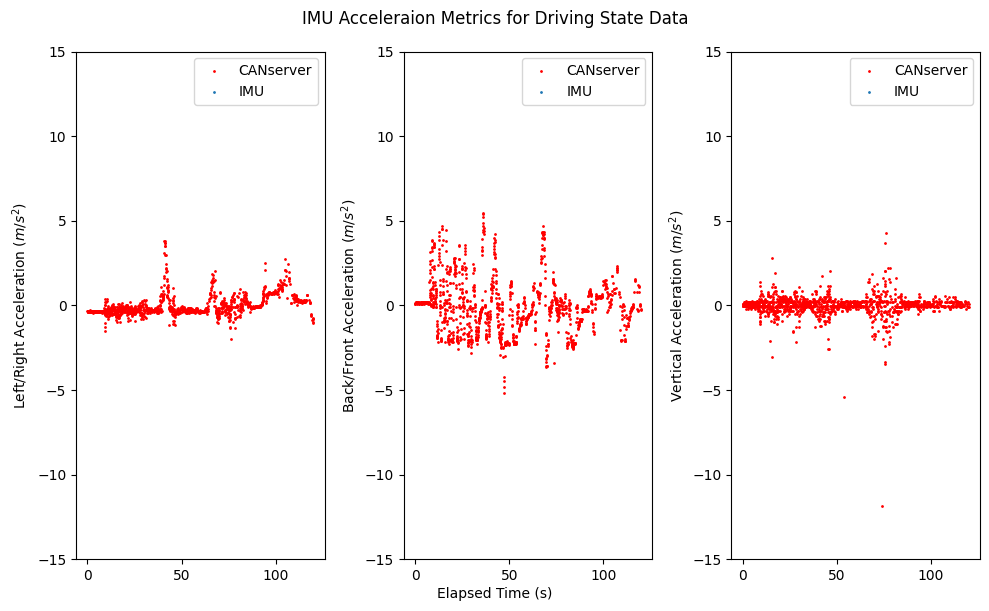

6


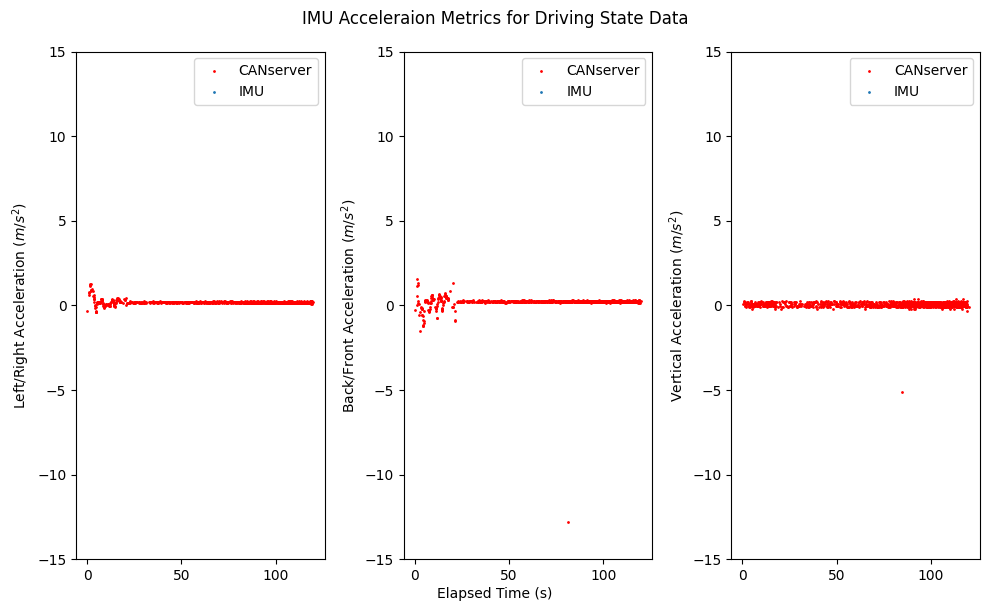

7


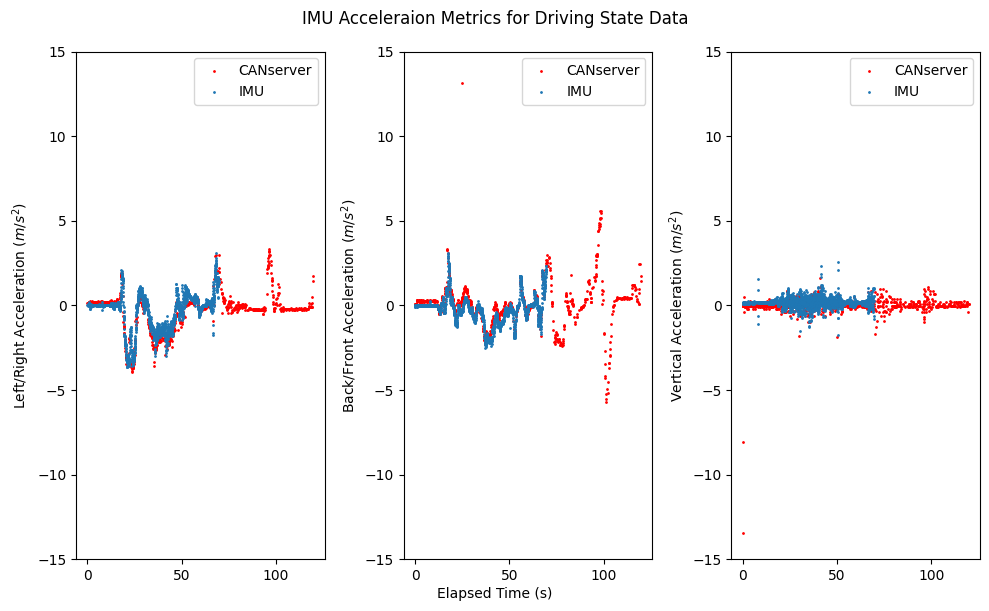

8


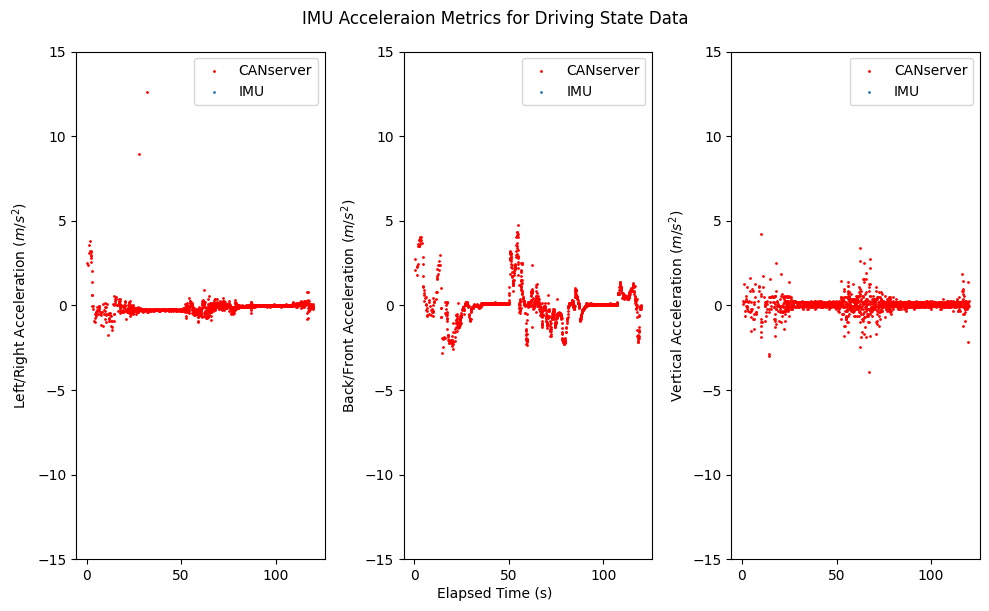

9


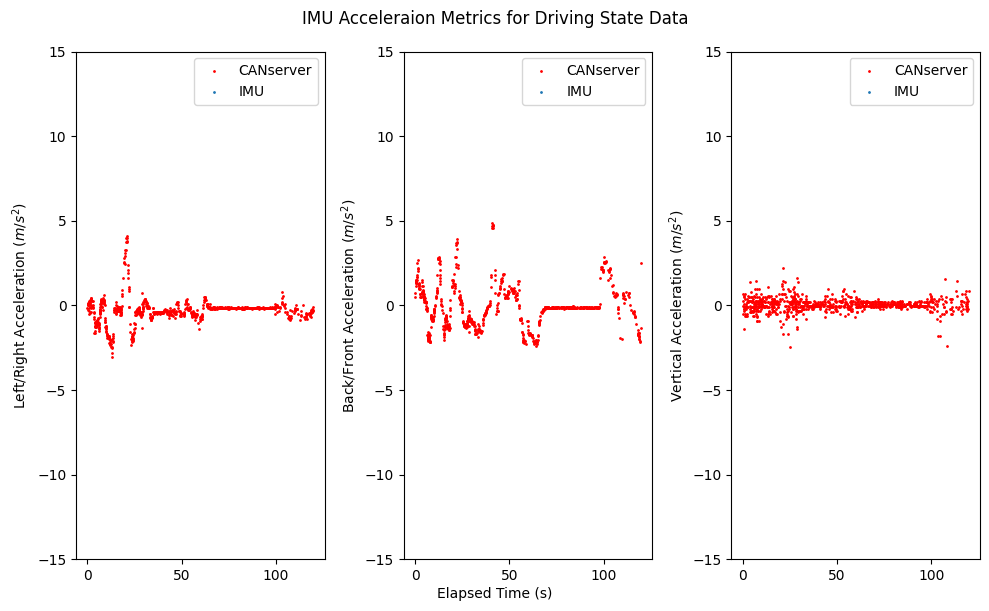

10


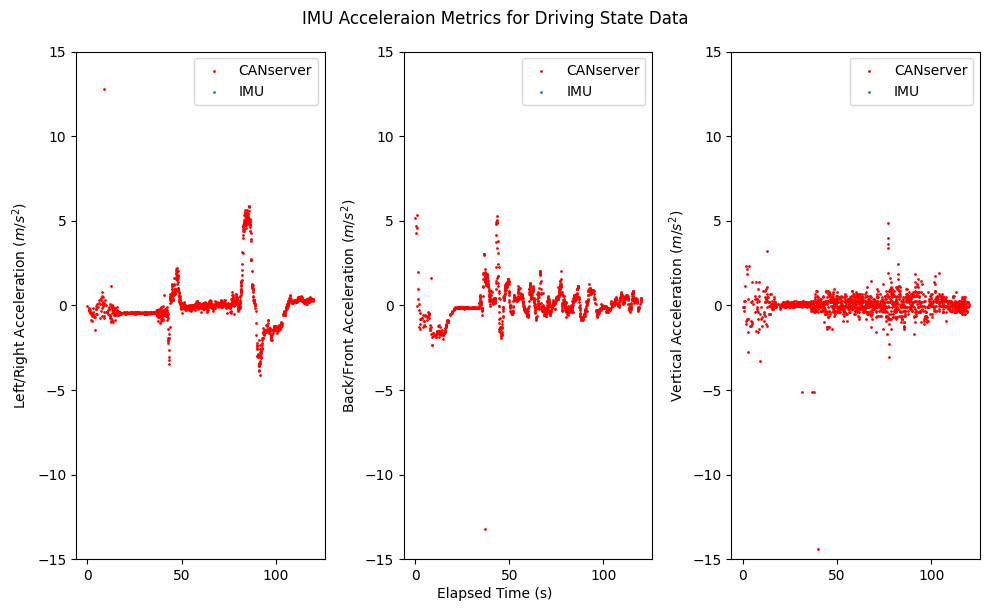

11


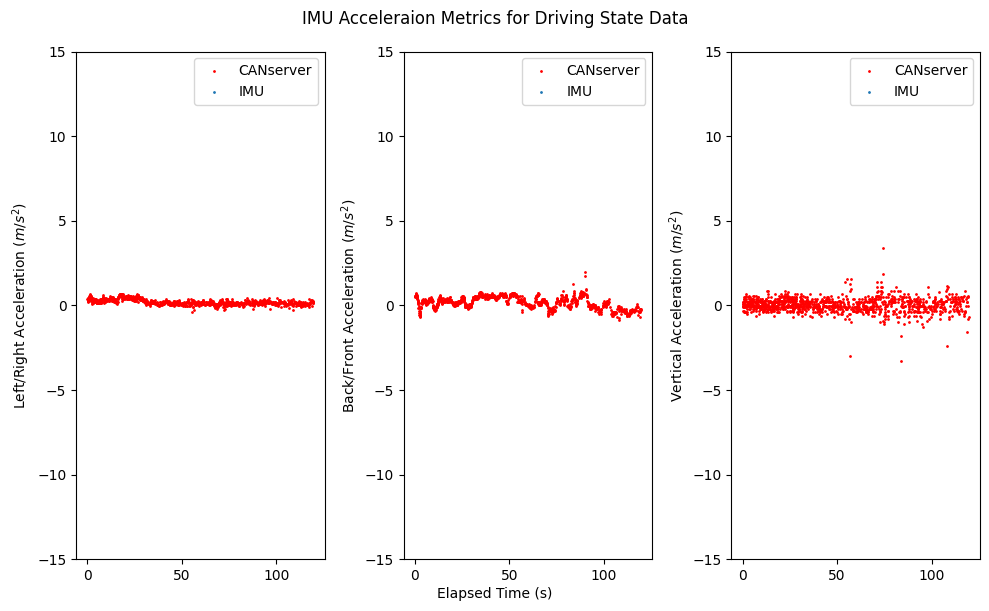

12


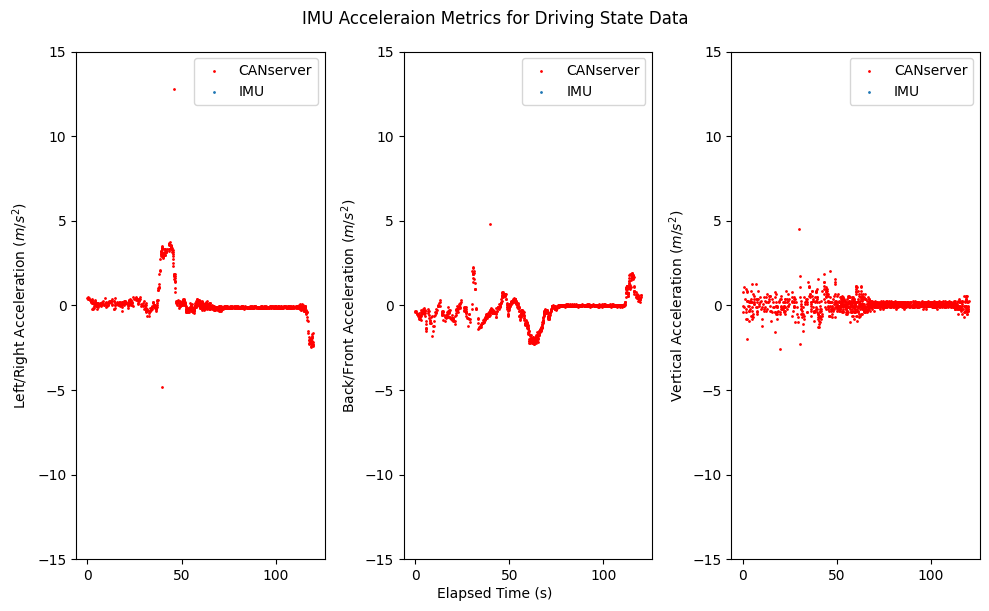

13


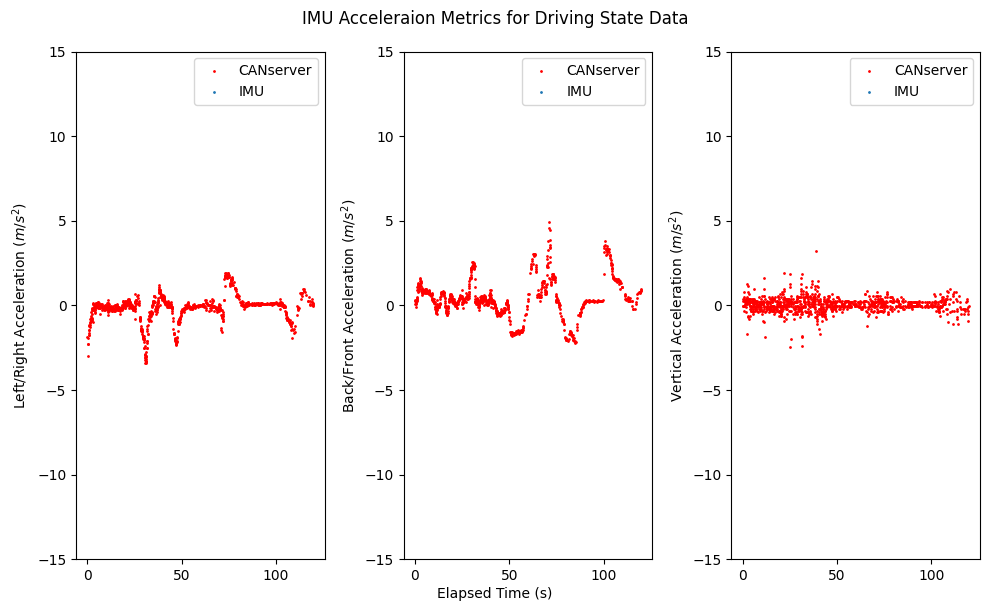

14


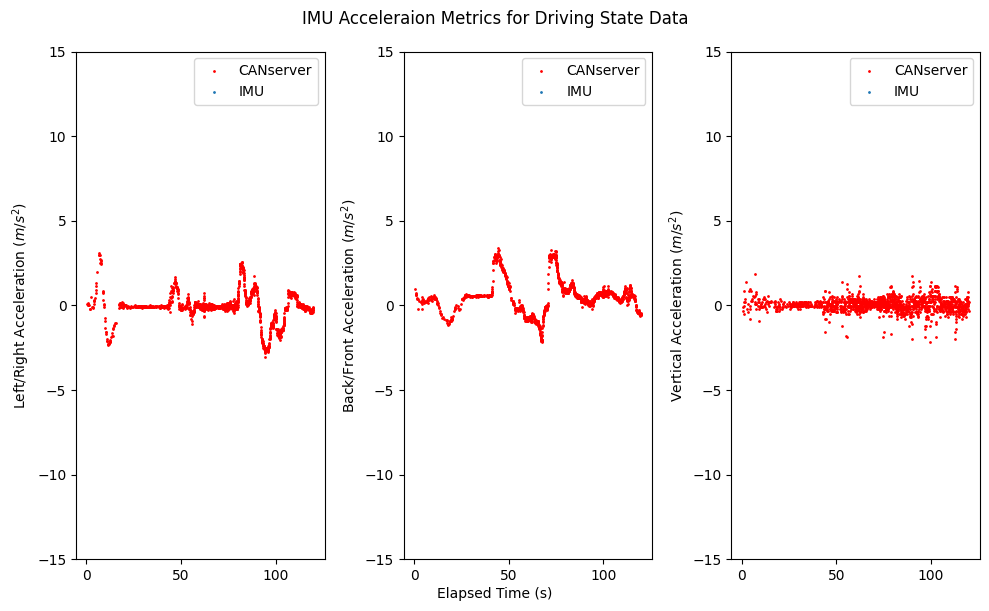

15


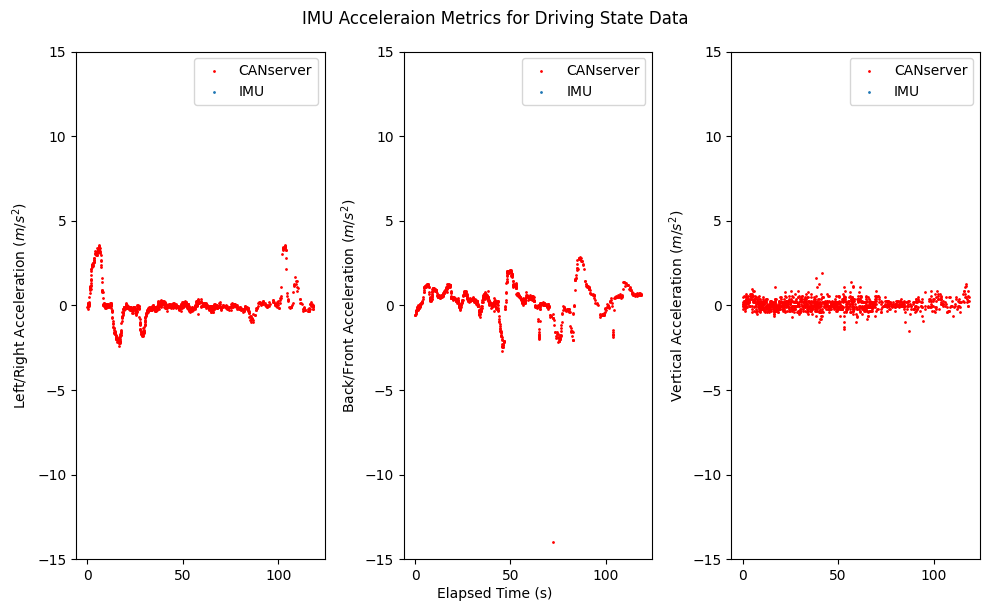

In [5]:
# plot driving state data in intervals of 120 seconds

window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = imu_df[(imu_df['timestamp(epoch in sec)'] >= dr_start_time) 
                        & (imu_df['timestamp(epoch in sec)'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and ((count == 8) or (count == 6))):
        if ( (len(can_motion) != 0) and (count < 20)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['timestamp(epoch in sec)'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['timestamp(epoch in sec)'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['timestamp(epoch in sec)'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()